# Hotel Booking Cancelation Classification - Cleaning & EDA
**By: Sarah Alabdulwahab & Asma Althakafi**
> Our goal is to classify the customers that will cancel their hotel booking and those that will not.

## Data Description 
> This dataset contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

In [1]:
# supress warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# data manipulation imports
import pandas as pd
import numpy as np
import re

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# web scraping imports
import requests
from bs4 import BeautifulSoup

## Hotel Booking Data

In [2]:
bookings_df = pd.read_csv("hotel_bookings.csv")
bookings_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
print('The dataset contains',bookings_df.shape[0],'observations and',bookings_df.shape[1],'features')

The dataset contains 119390 observations and 32 features


In [4]:
bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

### Cleaning

In [5]:
#check for nulls
bookings_df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
#Since company and agent have too many null values, we decided to drop them.
bookings_df.drop(columns=['company','agent'], inplace=True)

In [7]:
#drop nulls
bookings_df.dropna(inplace=True)

In [8]:
#check for duplicated rows
bookings_df.duplicated().sum()

31984

In [9]:
#remove duplicated rows but only keep the first occurance
bookings_df.drop_duplicates(keep="first",inplace=True) 

In [10]:
#reseting the index after dropping
bookings_df.reset_index(drop=True, inplace=True)

### Discovering the Features

**The numerical features**

In [11]:
num_features = list(bookings_df.select_dtypes(include= ['int64', 'float64']).columns)
print(num_features)

['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


In [12]:
print('There are',len(num_features),'numerical features')

There are 18 numerical features


**`lead_time`**: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.

In [13]:
#number of unique values
bookings_df.lead_time.nunique()

479

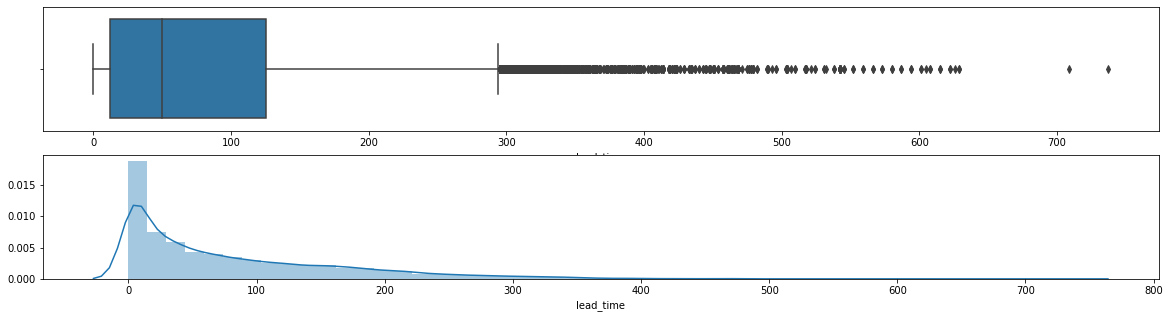

In [14]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("lead_time", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['lead_time'], ax=axs[1]);

In [15]:
#5 most occurring values
bookings_df.lead_time.value_counts().head()

0    5857
1    3148
2    1889
3    1689
4    1551
Name: lead_time, dtype: int64

In [16]:
#5 least occurring values
bookings_df.lead_time.value_counts().tail()

737    1
521    1
370    1
626    1
709    1
Name: lead_time, dtype: int64

In [17]:
#remove the outliers
Q1 = bookings_df['lead_time'].quantile(0.25)
Q3 = bookings_df['lead_time'].quantile(0.75)
IQR = Q3 - Q1 
bookings_df = bookings_df.loc[(bookings_df['lead_time'] >= Q1 - 1.5 * IQR) &
                              (bookings_df['lead_time'] <= Q3 + 1.5 *IQR)]

**`arrival_date_year`**: Year of arrival date.

In [18]:
#number of unique values
bookings_df.arrival_date_year.nunique()

3

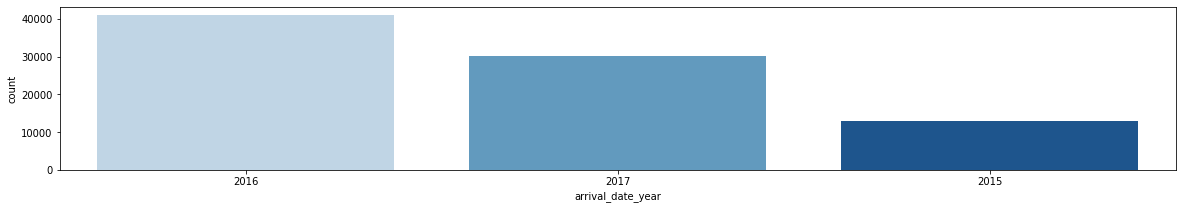

In [19]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['arrival_date_year'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['arrival_date_year'].value_counts().index);

In [20]:
#occurrance of values
bookings_df.arrival_date_year.value_counts()

2016    41164
2017    30266
2015    13014
Name: arrival_date_year, dtype: int64

**`arrival_date_week_number`**: Week number of year for arrival date.

In [21]:
#number of unique values
bookings_df.arrival_date_week_number.nunique()

53

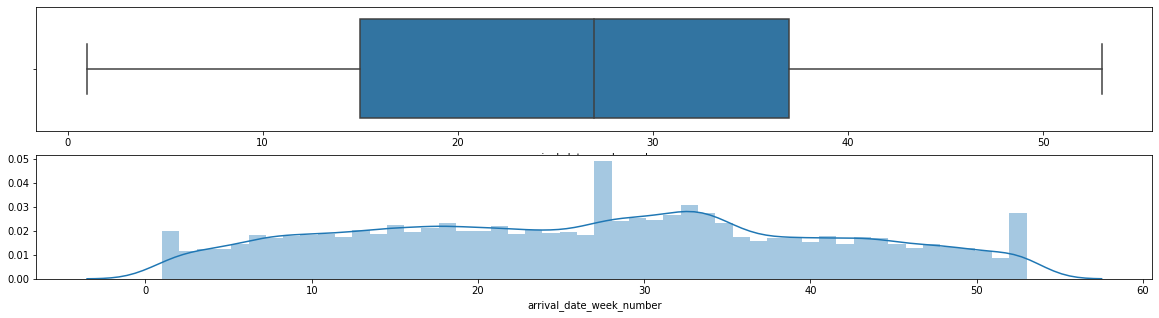

In [22]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("arrival_date_week_number", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['arrival_date_week_number'], ax=axs[1]);

In [23]:
#5 most occurring values
bookings_df.arrival_date_week_number.value_counts().head()

33    2713
34    2408
32    2348
28    2250
30    2236
Name: arrival_date_week_number, dtype: int64

In [24]:
#5 least occurring values
bookings_df.arrival_date_week_number.value_counts().tail()

50    1032
3     1022
2      932
1      843
51     764
Name: arrival_date_week_number, dtype: int64

**`arrival_date_day_of_month`**: Day of arrival date.

In [25]:
#number of unique values
bookings_df.arrival_date_day_of_month.nunique()

31

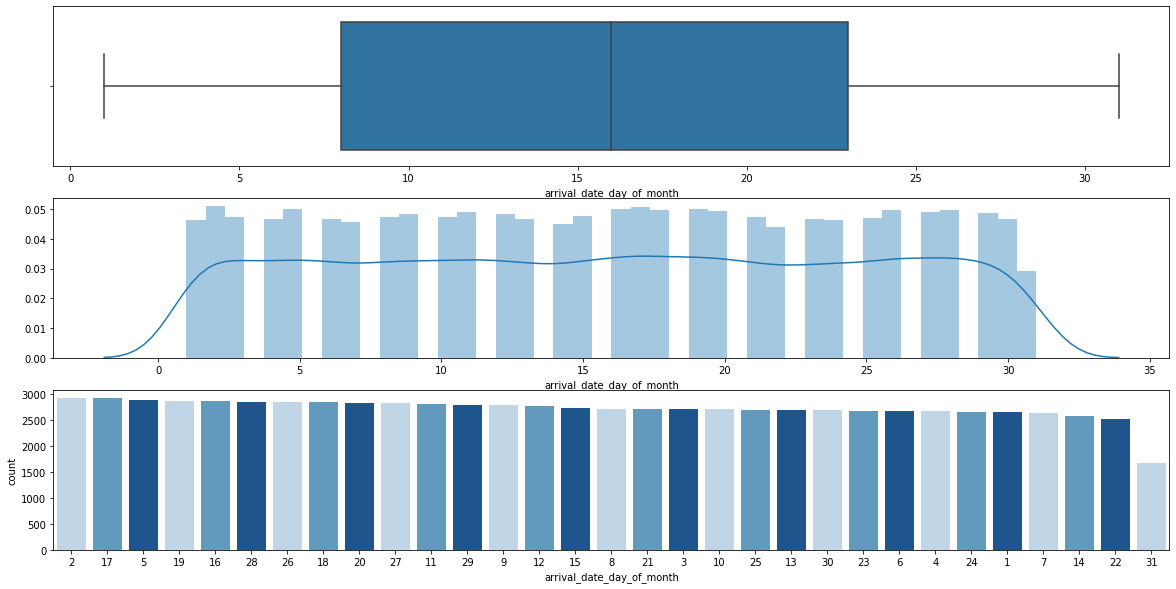

In [26]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("arrival_date_day_of_month", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['arrival_date_day_of_month'], ax=axs[1]);
sns.countplot(bookings_df['arrival_date_day_of_month'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['arrival_date_day_of_month'].value_counts().index, ax = axs[2]);

In [27]:
#5 most occurring values
bookings_df.arrival_date_day_of_month.value_counts().head()

2     2939
17    2923
5     2886
19    2876
16    2867
Name: arrival_date_day_of_month, dtype: int64

In [28]:
#5 least occurring values
bookings_df.arrival_date_day_of_month.value_counts().tail()

1     2656
7     2635
14    2580
22    2528
31    1685
Name: arrival_date_day_of_month, dtype: int64

**`stays_in_weekend_nights`**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel.

In [29]:
#number of unique values
bookings_df.stays_in_weekend_nights.nunique()

15

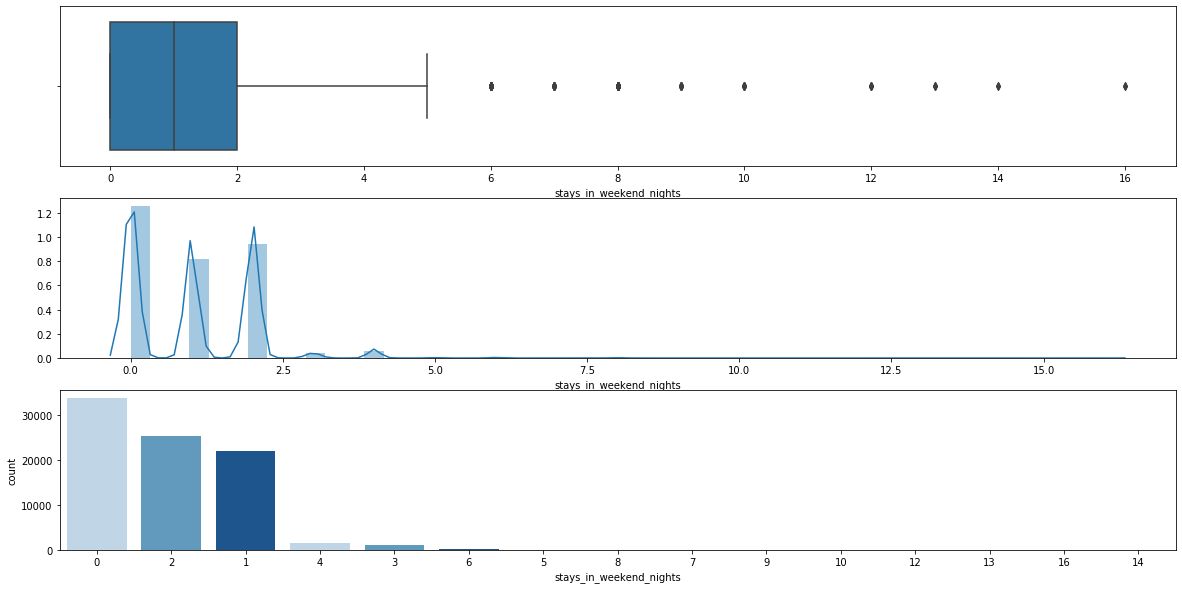

In [30]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("stays_in_weekend_nights", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['stays_in_weekend_nights'], ax=axs[1]);
sns.countplot(bookings_df['stays_in_weekend_nights'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['stays_in_weekend_nights'].value_counts().index, ax = axs[2]);

In [31]:
#5 most occurring values
bookings_df.stays_in_weekend_nights.value_counts().head()

0    33980
2    25449
1    22144
4     1539
3     1054
Name: stays_in_weekend_nights, dtype: int64

In [32]:
#5 least occurring values
bookings_df.stays_in_weekend_nights.value_counts().tail()

10    7
12    5
13    3
16    2
14    2
Name: stays_in_weekend_nights, dtype: int64

**`stays_in_week_nights`**: Number of weeknights (Monday to Friday) the guest stayed or booked to stay at the hotel.

In [33]:
#number of unique values
bookings_df.stays_in_week_nights.nunique()

33

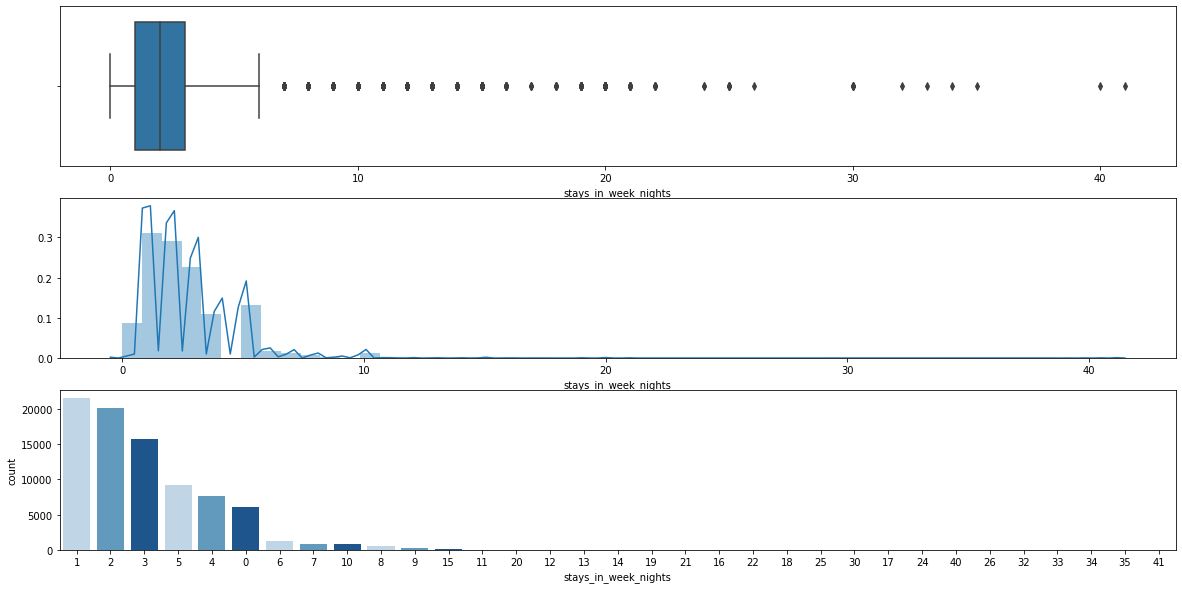

In [34]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("stays_in_week_nights", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['stays_in_week_nights'], ax=axs[1]);
sns.countplot(bookings_df['stays_in_week_nights'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['stays_in_week_nights'].value_counts().index, ax = axs[2]);

In [35]:
#5 most occurring values
bookings_df.stays_in_week_nights.value_counts().head()

1    21616
2    20162
3    15742
5     9145
4     7589
Name: stays_in_week_nights, dtype: int64

In [36]:
#5 least occurring values
bookings_df.stays_in_week_nights.value_counts().tail()

32    1
33    1
34    1
35    1
41    1
Name: stays_in_week_nights, dtype: int64

We decided to merge the two features: stays_in_weekend_nights and stays_in_week_nights in order to have one feature refering to the stay_nights

In [37]:
bookings_df['stay_nights'] = bookings_df['stays_in_weekend_nights'] + bookings_df['stays_in_week_nights']
bookings_df.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'], inplace=True)

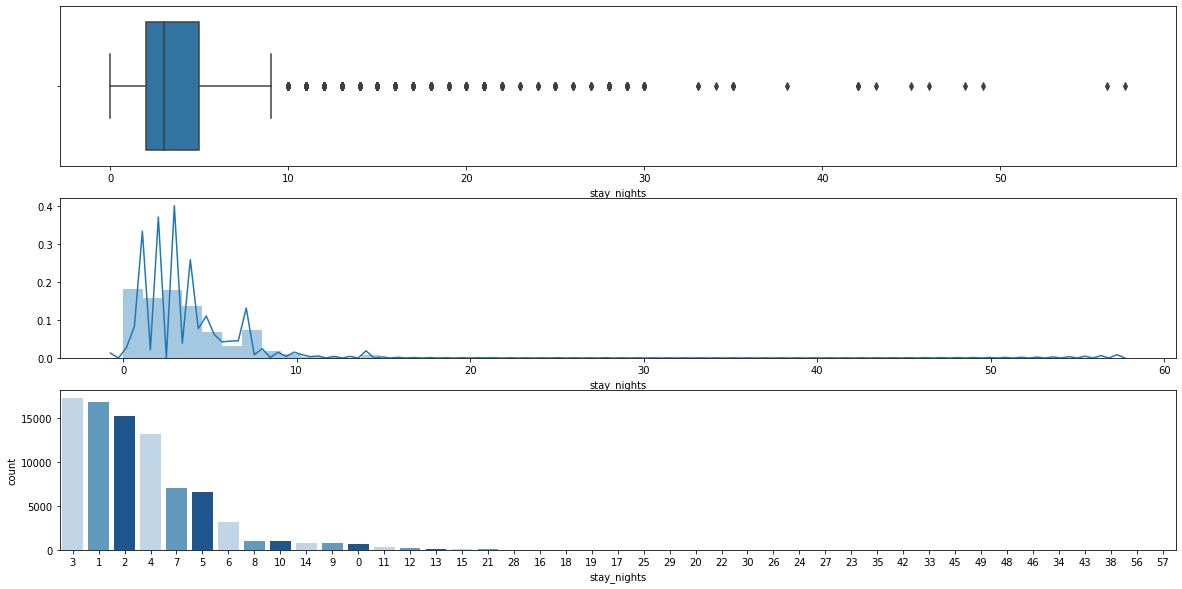

In [38]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("stay_nights", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['stay_nights'], ax=axs[1]);
sns.countplot(bookings_df['stay_nights'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['stay_nights'].value_counts().index, ax = axs[2]);

**`adults`**: Number of adults.

In [39]:
#number of unique values
bookings_df.adults.nunique()

5

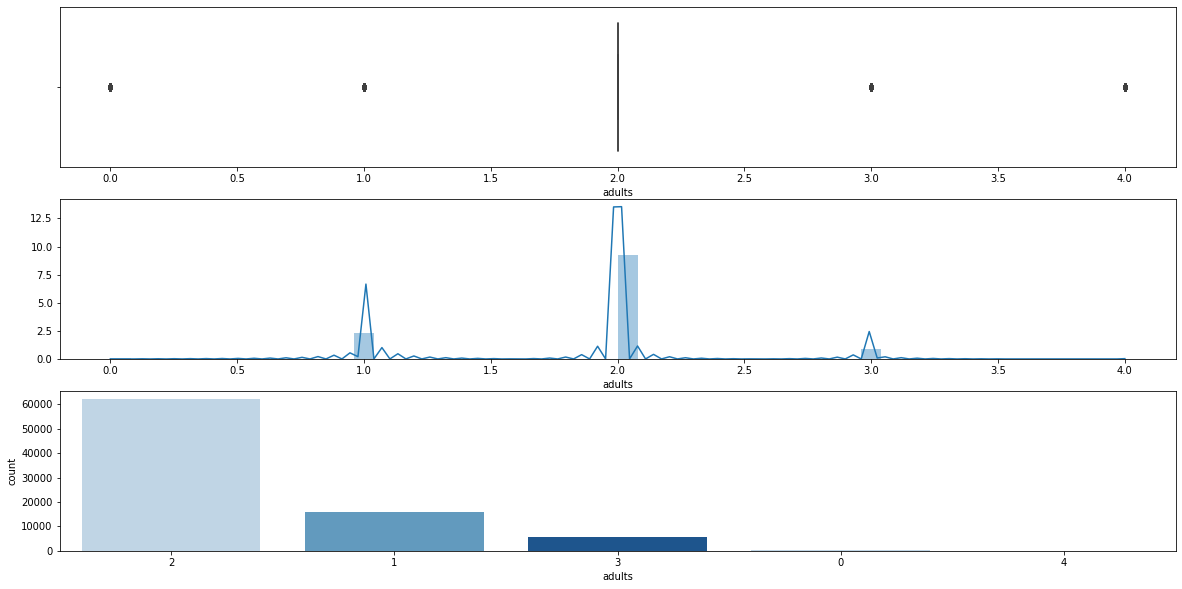

In [40]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("adults", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['adults'], ax=axs[1]);
sns.countplot(bookings_df['adults'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['adults'].value_counts().index, ax = axs[2]);

In [41]:
#5 most occurring values
bookings_df.adults.value_counts().head()

2    62395
1    15812
3     5815
0      364
4       58
Name: adults, dtype: int64

In [42]:
#5 least occurring values
bookings_df.adults.value_counts().tail()

2    62395
1    15812
3     5815
0      364
4       58
Name: adults, dtype: int64

It seems like there is a mistake in the adults feature, as 0 adults makes no sense. Therefore, we will exclude this value.

In [43]:
bookings_df = bookings_df[bookings_df.adults > 0]

**`children`**: Number of children.

In [44]:
#number of unique values
bookings_df.children.nunique()

5

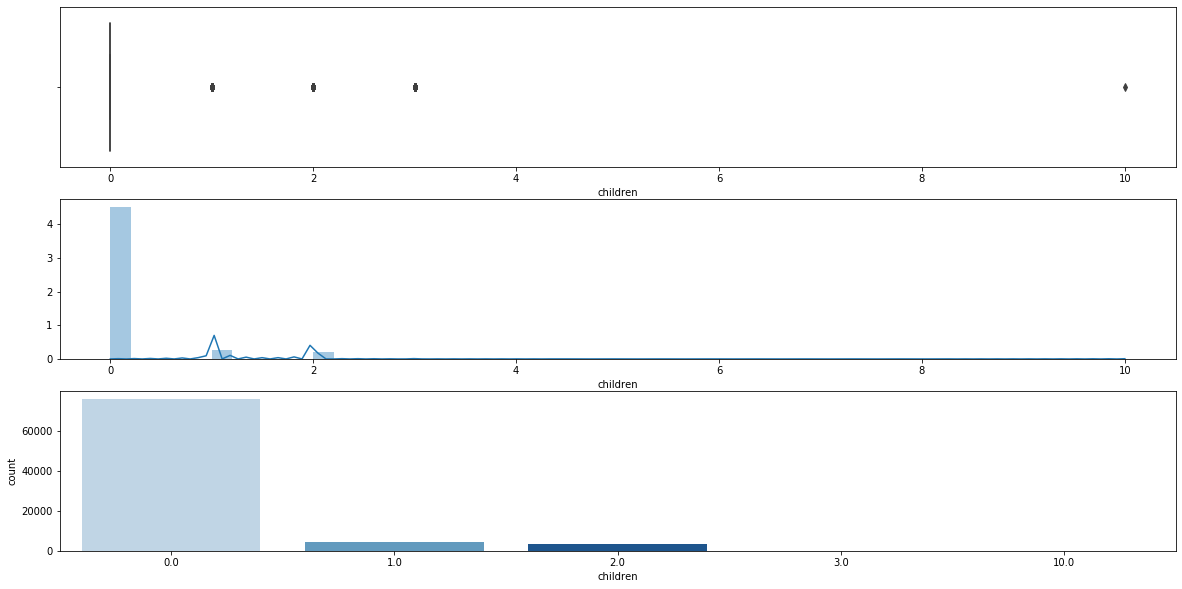

In [45]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("children", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['children'], ax=axs[1]);
sns.countplot(bookings_df['children'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['children'].value_counts().index, ax = axs[2]);

In [46]:
#occurrance of values
bookings_df.children.value_counts()

0.0     76159
1.0      4555
2.0      3301
3.0        64
10.0        1
Name: children, dtype: int64

In [47]:
#remove the outliers
bookings_df = bookings_df[bookings_df.children != 10]

**`babies`**: Number of babies.

In [48]:
#number of unique values
bookings_df.babies.nunique()

5

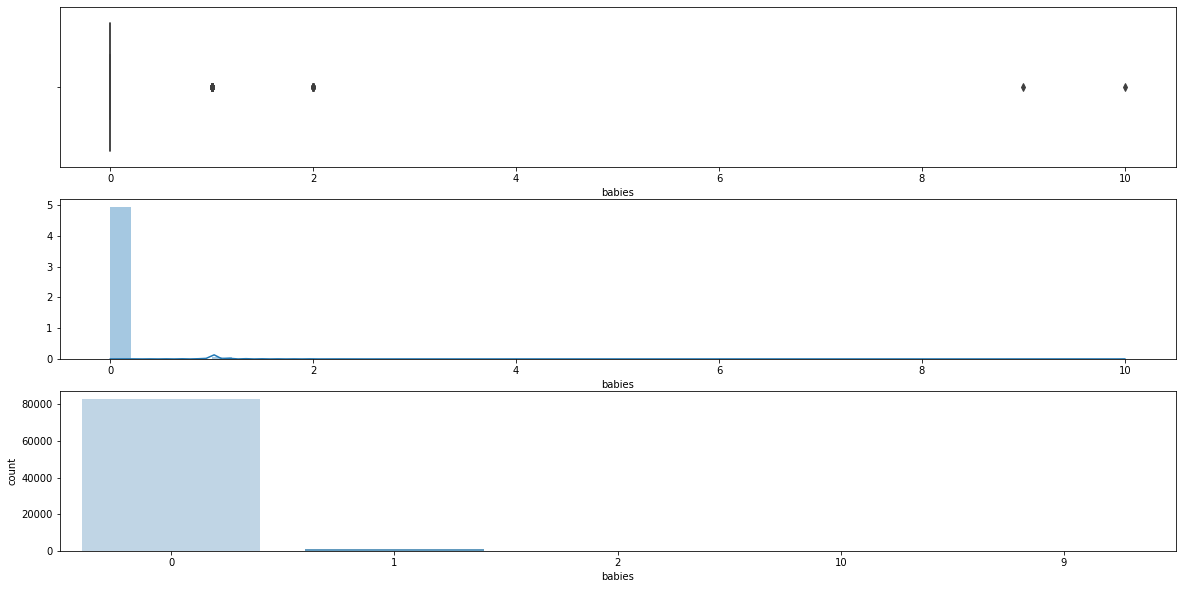

In [49]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("babies", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['babies'], ax=axs[1]);
sns.countplot(bookings_df['babies'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['babies'].value_counts().index, ax = axs[2]);

In [50]:
#occurrance of values
bookings_df.babies.value_counts()

0     83195
1       869
2        13
10        1
9         1
Name: babies, dtype: int64

In [51]:
#remove the outliers
bookings_df = bookings_df[bookings_df.babies < 2]

We decided to merge adults, children, and babies into one feature representing the number of people

In [52]:
bookings_df['total_people'] = bookings_df['adults'] + bookings_df['children'] + bookings_df['babies']
bookings_df.drop(columns=['adults', 'children', 'babies'], inplace=True)

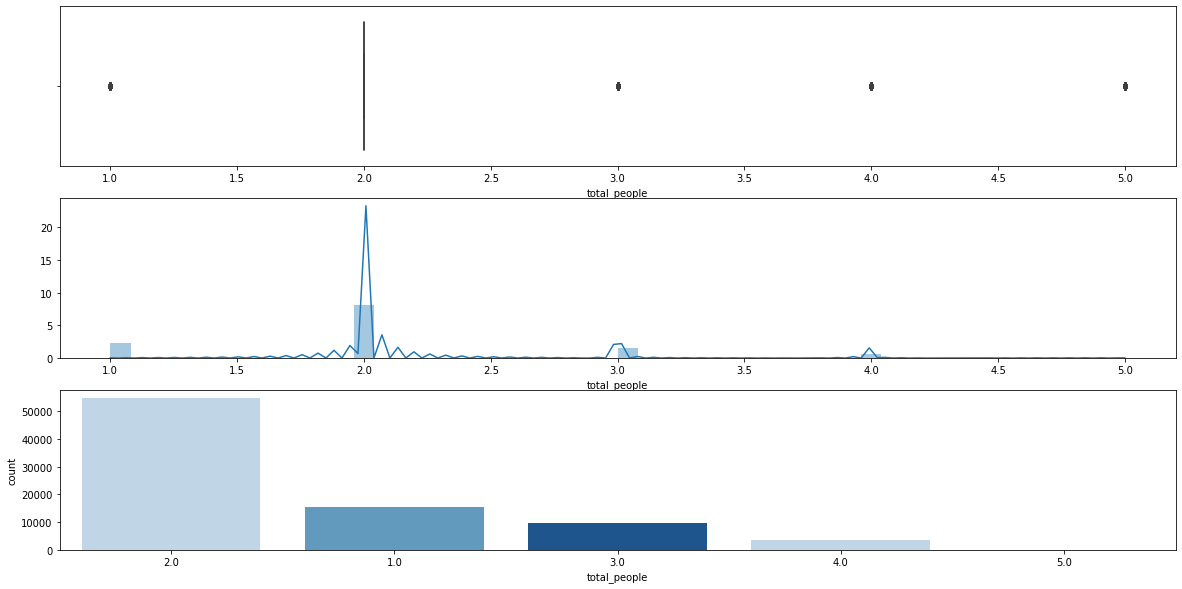

In [53]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("total_people", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['total_people'], ax=axs[1]);
sns.countplot(bookings_df['total_people'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['total_people'].value_counts().index, ax = axs[2]);

**`is_repeated_guest`**: Value indicating if the booking name was from a repeated guest (1) or not (0).

In [54]:
#number of unique values
bookings_df.is_repeated_guest.nunique()

2

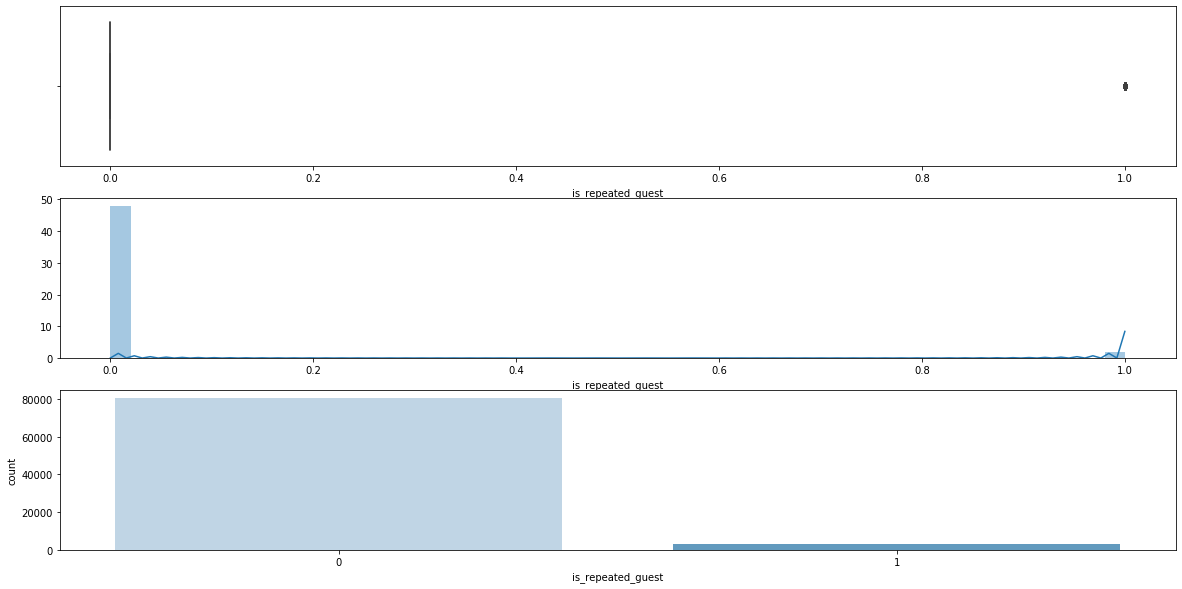

In [55]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("is_repeated_guest", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['is_repeated_guest'], ax=axs[1]);
sns.countplot(bookings_df['is_repeated_guest'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['is_repeated_guest'].value_counts().index, ax = axs[2]);

Evidently, the values are either 0 or 1, making this a categorical feature

In [56]:
#occurrance of values
bookings_df.is_repeated_guest.value_counts()

0    80726
1     3338
Name: is_repeated_guest, dtype: int64

**`previous_cancellations`**: Number of previous bookings that were canceled by the customer prior to the current booking.

In [57]:
#number of unique values
bookings_df.previous_cancellations.nunique()

15

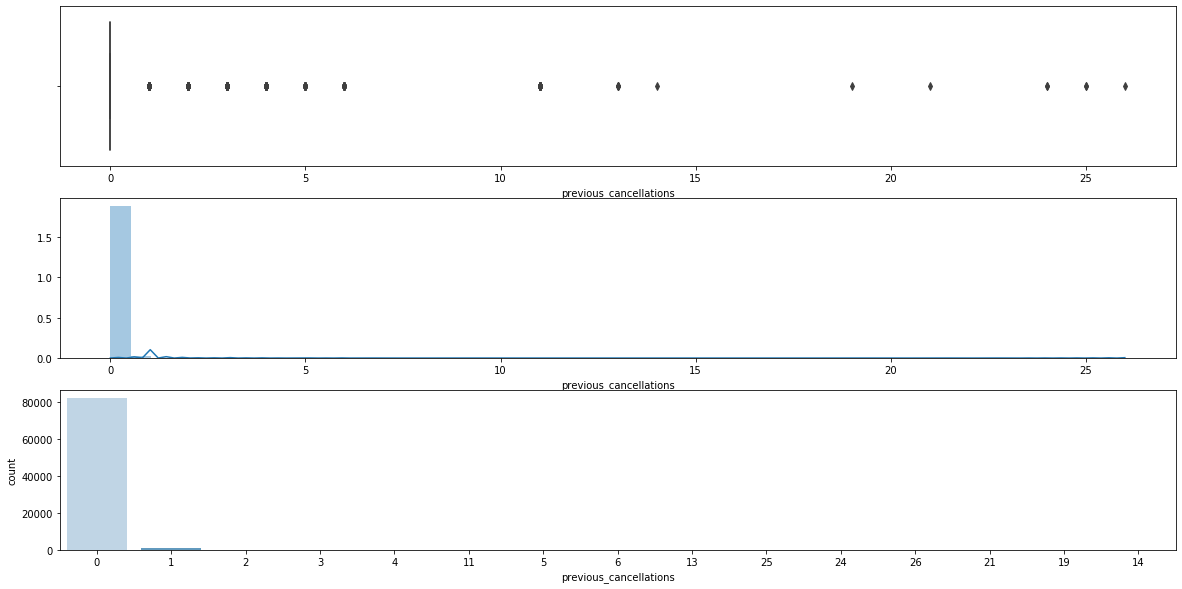

In [58]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("previous_cancellations", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['previous_cancellations'], ax=axs[1]);
sns.countplot(bookings_df['previous_cancellations'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['previous_cancellations'].value_counts().index, ax = axs[2]);

In [59]:
#5 most occurring values
bookings_df.previous_cancellations.value_counts().head()

0    82533
1     1262
2      103
3       61
4       30
Name: previous_cancellations, dtype: int64

In [60]:
#5 least occurring values
bookings_df.previous_cancellations.value_counts().tail()

24    2
26    1
21    1
19    1
14    1
Name: previous_cancellations, dtype: int64

**`previous_bookings_not_canceled`**: Number of previous bookings not canceled by the customer prior to the current booking.

In [61]:
#number of unique values
bookings_df.previous_bookings_not_canceled.nunique()

73

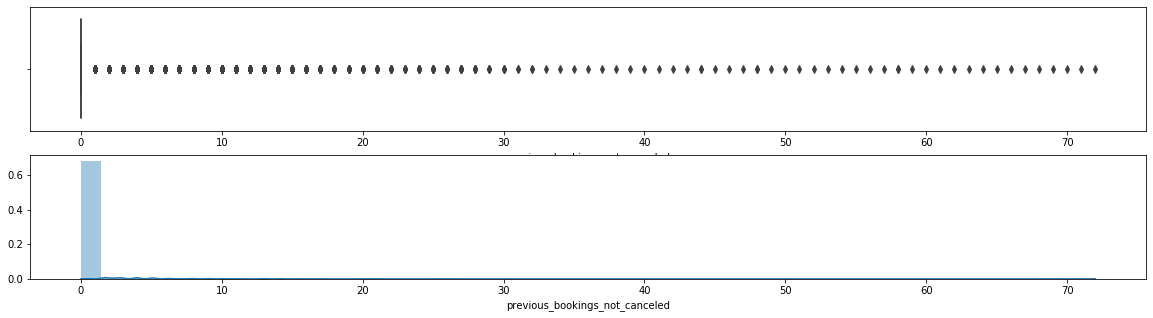

In [62]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("previous_bookings_not_canceled", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['previous_bookings_not_canceled'], ax=axs[1]);

In [63]:
#5 most occurring values
bookings_df.previous_bookings_not_canceled.value_counts().head()

0    80779
1     1368
2      532
3      299
4      205
Name: previous_bookings_not_canceled, dtype: int64

In [64]:
#5 least occurring values
bookings_df.previous_bookings_not_canceled.value_counts().tail()

47    1
36    1
49    1
50    1
63    1
Name: previous_bookings_not_canceled, dtype: int64

**`booking_changes`**: Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.

In [65]:
#number of unique values
bookings_df.booking_changes.nunique()

18

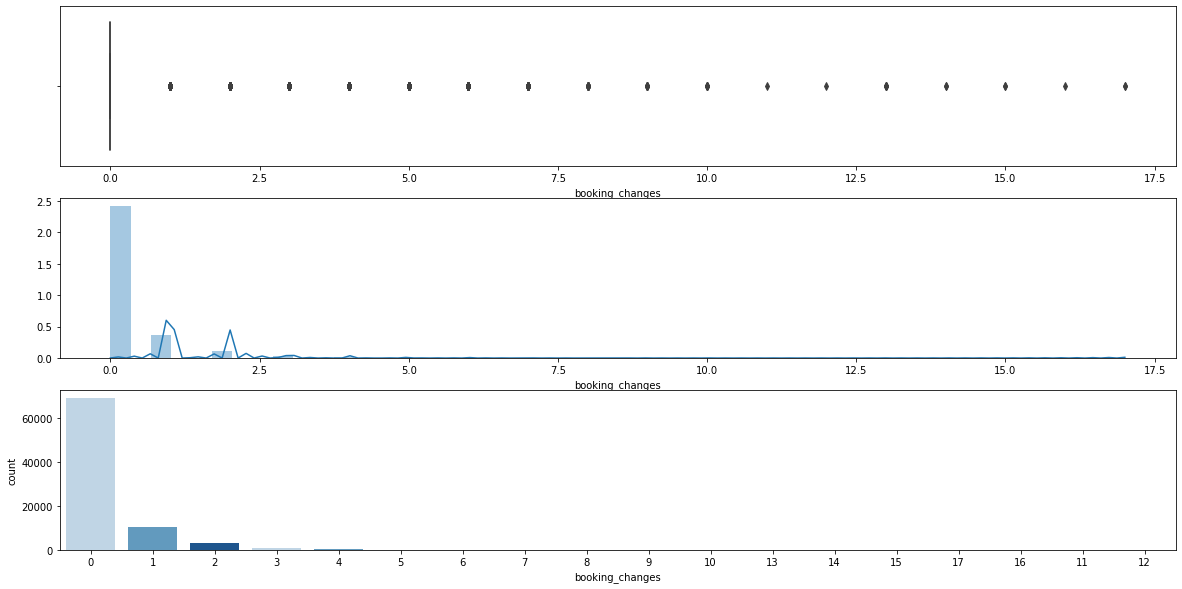

In [66]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("booking_changes", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['booking_changes'], ax=axs[1]);
sns.countplot(bookings_df['booking_changes'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['booking_changes'].value_counts().index, ax = axs[2]);

In [67]:
#5 most occurring values
bookings_df.booking_changes.value_counts().head()

0    69127
1    10278
2     3288
3      809
4      334
Name: booking_changes, dtype: int64

In [68]:
#5 least occurring values
bookings_df.booking_changes.value_counts().tail()

15    2
17    2
16    1
11    1
12    1
Name: booking_changes, dtype: int64

**`days_in_waiting_list`**: Number of days the booking was on the waiting list before it was confirmed to the customer.

In [69]:
#number of unique values
bookings_df.days_in_waiting_list.nunique()

113

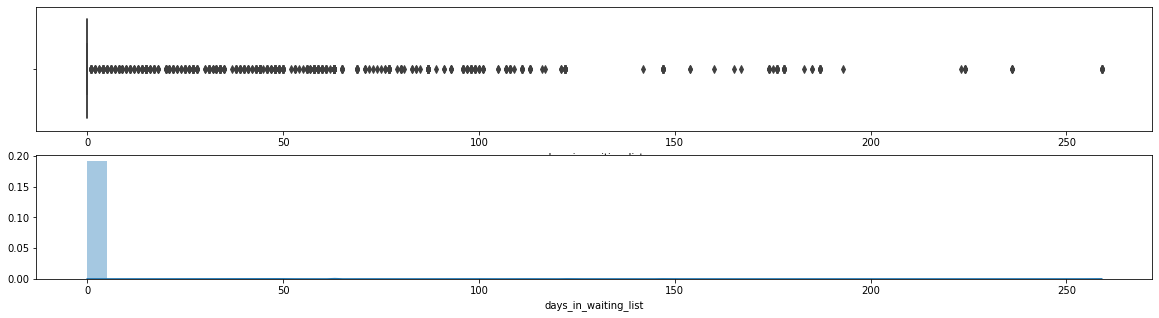

In [70]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("days_in_waiting_list", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['days_in_waiting_list'], ax=axs[1]);

In [71]:
#5 most occurring values
bookings_df.days_in_waiting_list.value_counts().head()

0     83324
63       53
87       25
44       23
15       22
Name: days_in_waiting_list, dtype: int64

In [72]:
#5 least occurring values
bookings_df.days_in_waiting_list.value_counts().tail()

142    1
117    1
54     1
75     1
79     1
Name: days_in_waiting_list, dtype: int64

In [73]:
#remove the outliers
bookings_df = bookings_df[bookings_df.days_in_waiting_list <= 100]

**`adr`**: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights.

In [74]:
#number of unique values
bookings_df.adr.nunique()

8705

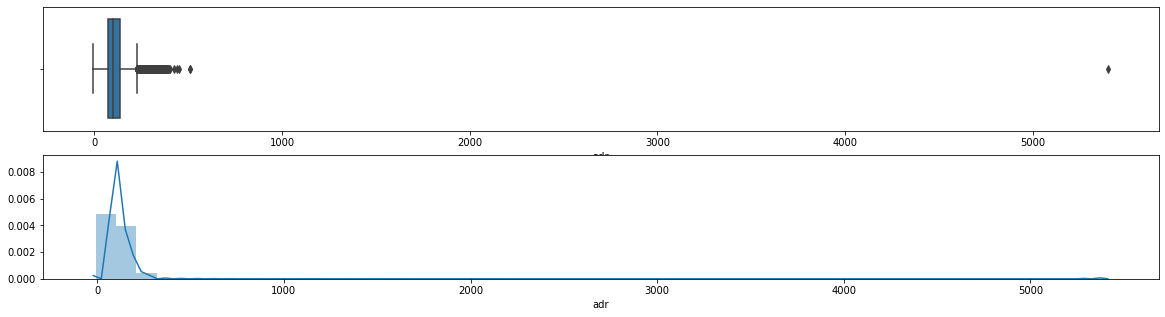

In [75]:
fig, axs = plt.subplots(2, figsize=(20,5))
sns.boxplot("adr", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['adr'], ax=axs[1]);

In [76]:
#5 most occurring values
bookings_df.adr.value_counts().head()

0.0     1571
75.0    1293
65.0    1217
85.0     855
95.0     842
Name: adr, dtype: int64

In [77]:
#5 least occurring values
bookings_df.adr.value_counts().tail()

37.71     1
99.06     1
32.31     1
67.38     1
131.44    1
Name: adr, dtype: int64

In [78]:
#remove the outliers
Q1 = bookings_df['adr'].quantile(0.25)
Q3 = bookings_df['adr'].quantile(0.75)
IQR = Q3 - Q1 
bookings_df = bookings_df.loc[(bookings_df['adr'] >= Q1 - 1.5 * IQR)&(bookings_df['adr'] <= Q3 + 1.5 *IQR)]

**`required_car_parking_spaces`**: Number of car parking spaces required by the customer.

In [79]:
#number of unique values
bookings_df.required_car_parking_spaces.nunique()

5

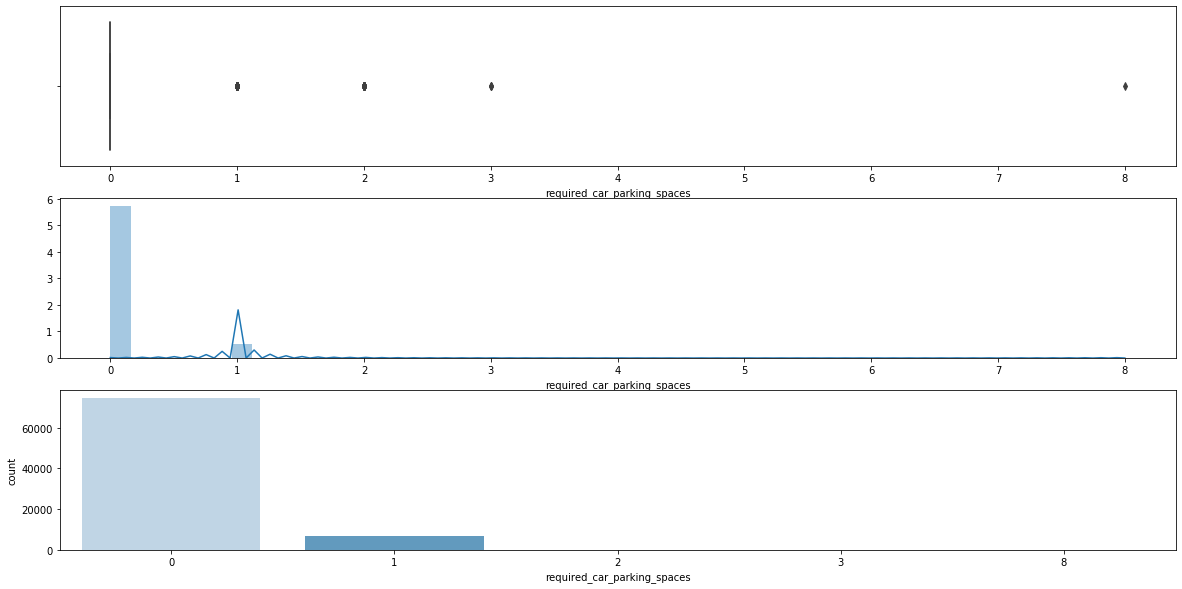

In [80]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("required_car_parking_spaces", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['required_car_parking_spaces'], ax=axs[1]);
sns.countplot(bookings_df['required_car_parking_spaces'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['required_car_parking_spaces'].value_counts().index, ax = axs[2]);

In [81]:
#occurrance of values
bookings_df.required_car_parking_spaces.value_counts()

0    74808
1     6684
2       24
3        3
8        1
Name: required_car_parking_spaces, dtype: int64

In [82]:
#remove the outliers
bookings_df = bookings_df[bookings_df.required_car_parking_spaces <= 2]

**`total_of_special_requests`**: Number of special requests made by the customer (e.g. twin bed or high floor).

In [83]:
#number of unique values
bookings_df.total_of_special_requests.nunique()

6

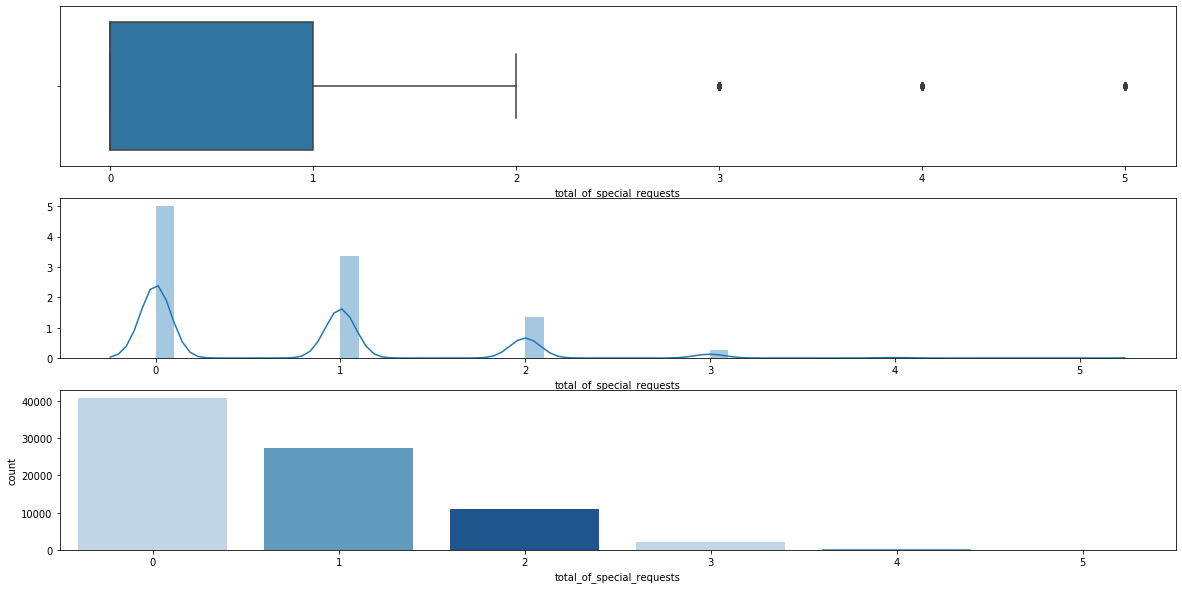

In [84]:
fig, axs = plt.subplots(3, figsize=(20,10))
sns.boxplot("total_of_special_requests", data=bookings_df, ax=axs[0]);
sns.distplot(bookings_df['total_of_special_requests'], ax=axs[1]);
sns.countplot(bookings_df['total_of_special_requests'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['total_of_special_requests'].value_counts().index, ax = axs[2]);

In [85]:
#occurrance of values
bookings_df.total_of_special_requests.value_counts()

0    40853
1    27292
2    10969
3     2094
4      278
5       30
Name: total_of_special_requests, dtype: int64

In [86]:
#remove the outliers
bookings_df = bookings_df[bookings_df.total_of_special_requests != 5]

**The categorical features**

In [87]:
cat_features = list(bookings_df.select_dtypes(include= ['object']).columns)
print(cat_features)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'reservation_status_date']


In [88]:
print('There are', len(cat_features),'categorical features')

There are 12 categorical features


**`hotel`**: Resort Hotel or City Hotel.

In [89]:
#number of unique values
bookings_df.hotel.nunique()

2

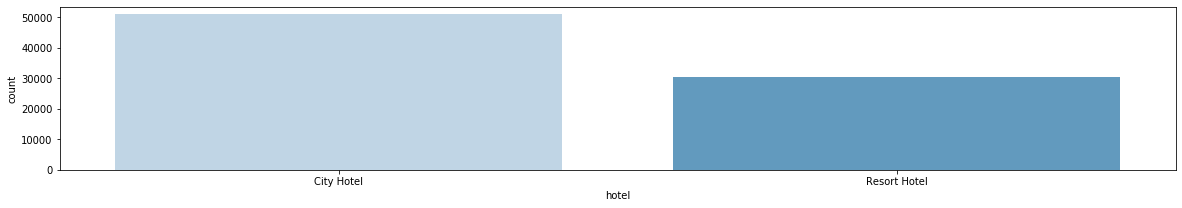

In [90]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['hotel'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['hotel'].value_counts().index);

In [91]:
#occurrance of values
bookings_df.hotel.value_counts()

City Hotel      50921
Resort Hotel    30565
Name: hotel, dtype: int64

**`arrival_date_month`**: Month of arrival date.

In [92]:
#number of unique values
bookings_df.arrival_date_month.nunique()

12

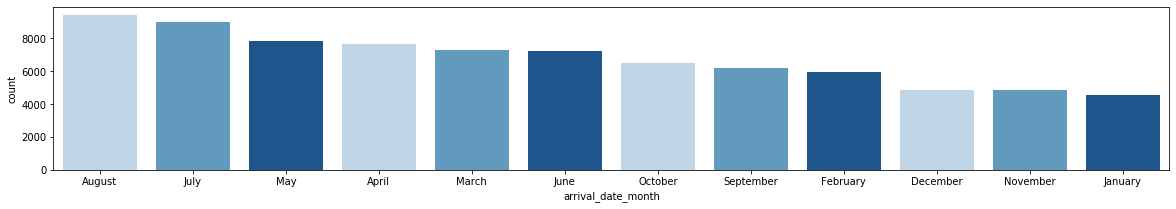

In [93]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['arrival_date_month'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['arrival_date_month'].value_counts().index);

In [94]:
#5 most occurring values
bookings_df.arrival_date_month.value_counts().head()

August    9454
July      9032
May       7845
April     7652
March     7319
Name: arrival_date_month, dtype: int64

In [95]:
#5 least occurring values
bookings_df.arrival_date_month.value_counts().tail()

September    6176
February     5952
December     4885
November     4872
January      4571
Name: arrival_date_month, dtype: int64

**`meal`**: Type of meal booked. Categories are presented in standard hospitality meal packages: 
- Undefined/SC – no meal package
- BB – Bed & Breakfast
- HB – Half board (breakfast and one other meal – usually dinner)
- FB – Full board (breakfast, lunch, and dinner)

In [96]:
#number of unique values
bookings_df.meal.nunique()

5

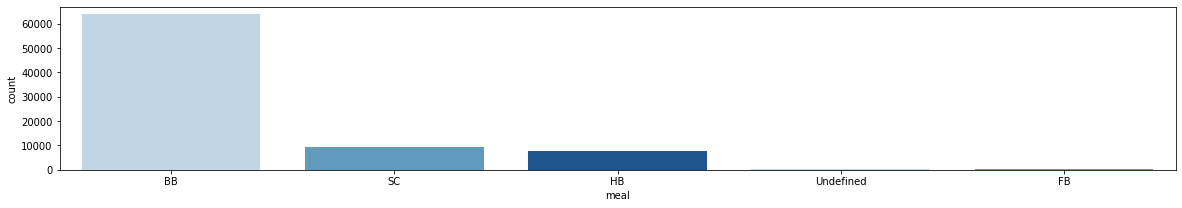

In [97]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['meal'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['meal'].value_counts().index);

In [98]:
#occurrance of values
bookings_df.meal.value_counts()

BB           63840
SC            9268
HB            7654
Undefined      433
FB             291
Name: meal, dtype: int64

We will replace SC and Undefined (because they refer to the same thing) with 'No Meal'.

In [99]:
bookings_df.meal = bookings_df.meal.str.replace('SC','No Meal').str.replace('Undefined','No Meal')

**`country`**: Country of origin. Categories are represented in the ISO 3155–3:2013 format.

In [100]:
#number of unique values
bookings_df.country.nunique()

174

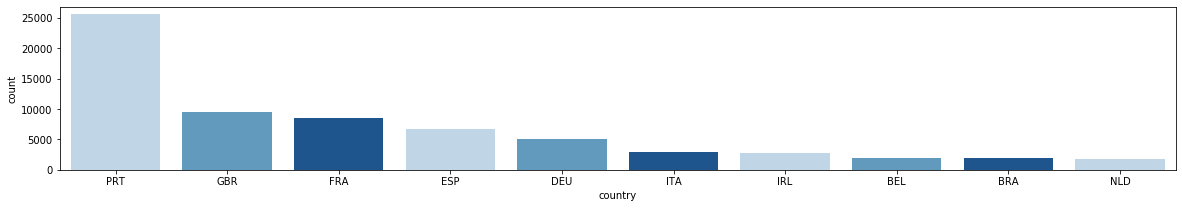

In [101]:
#Top 10
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['country'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['country'].value_counts().index[:10]);

In [102]:
#5 most occurring values
bookings_df.country.value_counts().head()

PRT    25566
GBR     9538
FRA     8507
ESP     6724
DEU     5095
Name: country, dtype: int64

In [103]:
#5 least occurring values
bookings_df.country.value_counts().tail()

MYT    1
NAM    1
NCL    1
MMR    1
SDN    1
Name: country, dtype: int64

In [104]:
#remove the outliers
bookings_df = bookings_df[bookings_df['country'].map(bookings_df['country'].value_counts()) >= 10]

Since the values of the countries are represented in an uninterpretable format, we decided to convert them into their actual names. To accomplish this, we had to scrape the data from Wikipedia.

In [105]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes')
soup = BeautifulSoup(page.content, "html.parser")

countries_data = []
for x in soup.find_all('table')[0].find_all('td'):
    if '– See' in x.text.strip(): #skip these because they were empty rows
        continue
    countries_data.append(x.text.strip())

In [106]:
countries_data[:10]

['Afghanistan',
 'The Islamic Republic of Afghanistan',
 'UN member state',
 '.mw-parser-output .monospaced{font-family:monospace,monospace}AF',
 'AFG',
 '004',
 'ISO 3166-2:AF',
 '.af',
 'Åland Islands',
 'Åland']

Now we just need to extract the country codes and their names.

In [107]:
#country codes
country_codes = countries_data[4::8]
print(country_codes[:10])

['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG']


In [108]:
#country names
country_names = countries_data[::8]
print(country_names[:10])

['Afghanistan', 'Åland Islands', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antarctica\u200a[a]', 'Antigua and Barbuda']


In [109]:
clean_country_names = []
for c in country_names:
    c = c.replace('\xa0',' ')
    name = re.sub(r'\([^)]*\)', '', c) #this removes () and everything in between
    name2 = re.sub(r'\[.*\]', '', name) #this removes [] and everything in between
    if ',' in name2: #ex: 'Tanzania, the United Republic of', we only want the first part
        clean_country_names.append(name2.split(',')[0].strip()) 
    else:
        clean_country_names.append(name2.strip())

In [110]:
#replacing the codes with the names of the countries
for i in range(len(country_codes)):
    bookings_df.country = bookings_df.country.str.replace(country_codes[i], clean_country_names[i])

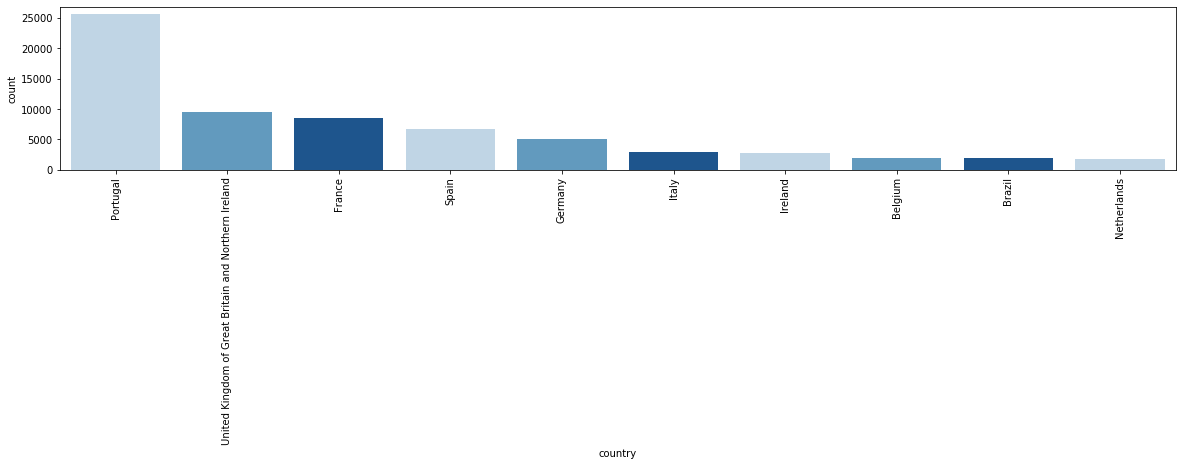

In [111]:
#Top 10
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['country'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['country'].value_counts().index[:10]);
plt.xticks(rotation='90');

**`market_segment`**: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”.

In [112]:
#number of unique values
bookings_df.market_segment.nunique()

7

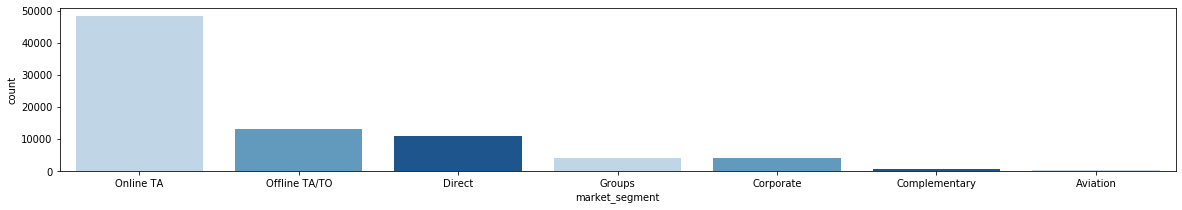

In [113]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['market_segment'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['market_segment'].value_counts().index);

In [114]:
#occurrance of values
bookings_df.market_segment.value_counts()

Online TA        48440
Offline TA/TO    12962
Direct           10821
Groups            4106
Corporate         3999
Complementary      683
Aviation           225
Name: market_segment, dtype: int64

**`distribution_channel`**: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”.

In [115]:
#number of unique values
bookings_df.distribution_channel.nunique()

5

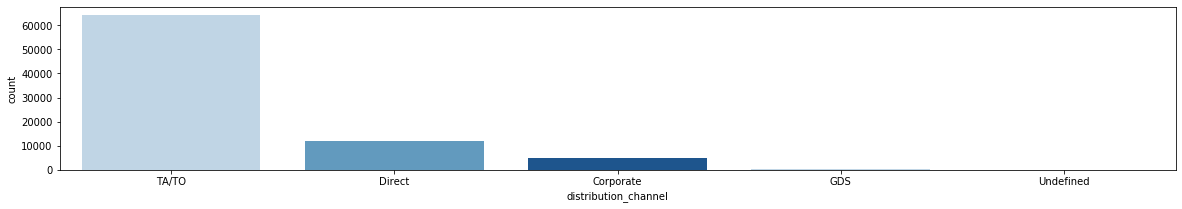

In [116]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['distribution_channel'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['distribution_channel'].value_counts().index);

In [117]:
#occurrance of values
bookings_df.distribution_channel.value_counts()

TA/TO        64422
Direct       11890
Corporate     4742
GDS            181
Undefined        1
Name: distribution_channel, dtype: int64

In [118]:
#remove the outliers 
bookings_df = bookings_df[bookings_df['distribution_channel'] != 'Undefined']

**`reserved_room_type`**: Code of room type reserved. Code is presented instead of designation for anonymity reasons.

In [119]:
#number of unique values
bookings_df.reserved_room_type.nunique()

9

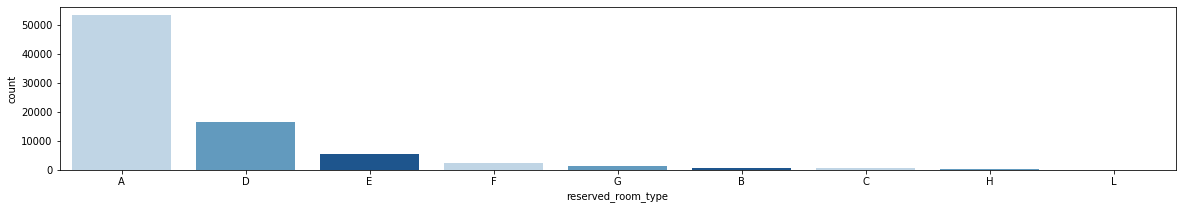

In [120]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['reserved_room_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['reserved_room_type'].value_counts().index);

In [121]:
#occurrance of values
bookings_df.reserved_room_type.value_counts()

A    53627
D    16582
E     5434
F     2313
G     1405
B      735
C      726
H      407
L        6
Name: reserved_room_type, dtype: int64

In [122]:
#remove the outliers
bookings_df = bookings_df[bookings_df['reserved_room_type'] != 'L']

**`assigned_room_type`**: Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.

In [123]:
#number of unique values
bookings_df.assigned_room_type.nunique()

10

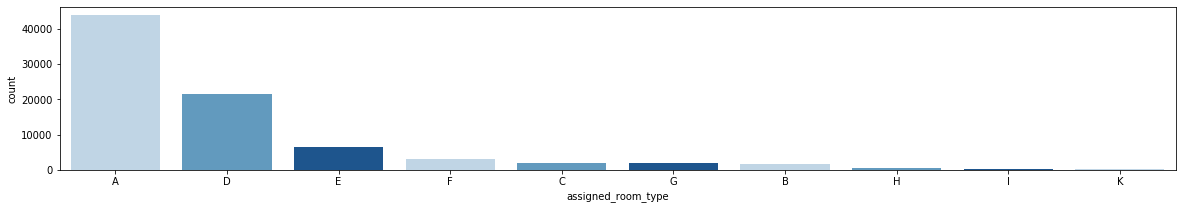

In [124]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['assigned_room_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['assigned_room_type'].value_counts().index);

In [125]:
#occurrance of values
bookings_df.assigned_room_type.value_counts()

A    43963
D    21420
E     6536
F     3083
C     1874
G     1814
B     1527
H      506
I      325
K      181
Name: assigned_room_type, dtype: int64

**`deposit_type`**: Indication on if the customer deposited to guarantee the booking. This variable can assume three categories: 
- No Deposit – no deposit was made
- Non Refund – a deposit was made in the value of the total stay cost
- Refundable – a deposit was made with a value under the total cost of the stay 


In [126]:
#number of unique values
bookings_df.deposit_type.nunique()

3

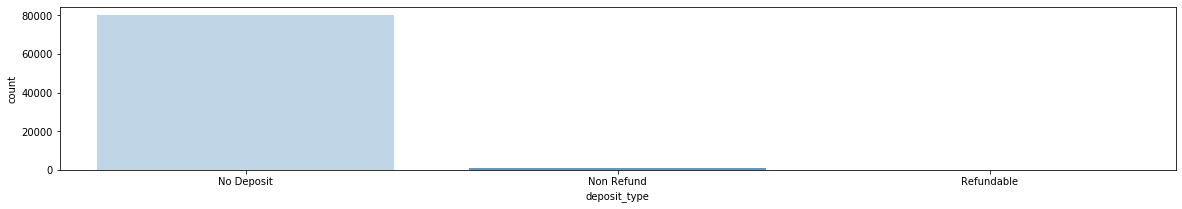

In [127]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['deposit_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['deposit_type'].value_counts().index);

In [128]:
#occurrance of values
bookings_df.deposit_type.value_counts()

No Deposit    80393
Non Refund      741
Refundable       95
Name: deposit_type, dtype: int64

**`customer_type`**: Type of booking, assuming one of four categories: 
- Contract – when the booking has an allotment or other type of contract associated with it
- Group – when the booking is associated with a group
- Transient – when the booking is not part of a group or contract and is not associated with another transient booking
- Transient-party – when the booking is transient but is associated with at least another transient booking

In [129]:
#number of unique values
bookings_df.customer_type.nunique()

4

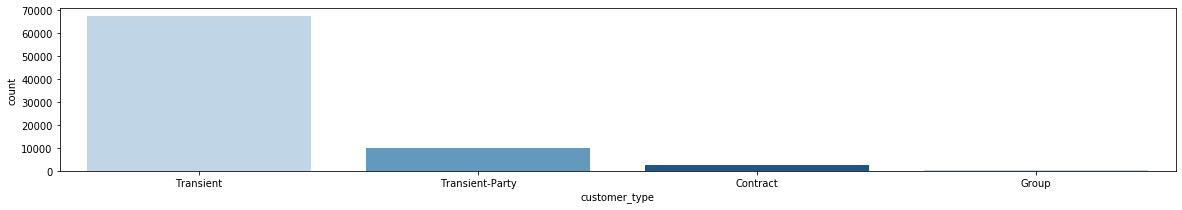

In [130]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['customer_type'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['customer_type'].value_counts().index);

In [131]:
#occurrance of values
bookings_df.customer_type.value_counts()

Transient          67476
Transient-Party    10356
Contract            2904
Group                493
Name: customer_type, dtype: int64

**`reservation_status`**: Reservation’s last status, assuming one of three categories: 
- Canceled – booking was canceled by the customer
- Check-Out – customer has checked in but already departed
- No-Show – the customer did not check-in and did inform the hotel of the reason why

In [132]:
#number of unique values
bookings_df.reservation_status.nunique()

3

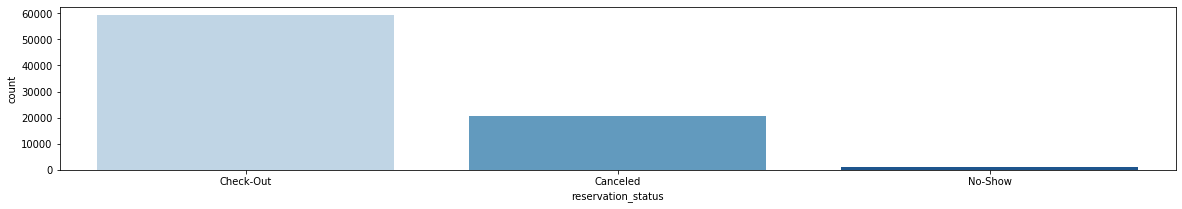

In [133]:
plt.figure(figsize=(20,3))
sns.countplot(bookings_df['reservation_status'], palette = sns.color_palette("Blues")[1::2], 
              order = bookings_df['reservation_status'].value_counts().index);

In [134]:
#occurrance of values
bookings_df.reservation_status.value_counts()

Check-Out    59494
Canceled     20759
No-Show        976
Name: reservation_status, dtype: int64

This feature has direct relation with our target, as in it tells us if the booking was canceled, therefore, it should be dropped along with **`reservation_status_date`** (Date at which the last status was set)

In [135]:
bookings_df.drop(columns=['reservation_status','reservation_status_date'], inplace=True)

**The target feature**

**`is_canceled`**: Value indicating if the booking was canceled (1) or not (0).

In [136]:
target_counts = bookings_df.is_canceled.value_counts()
print('There are',target_counts[1],'positive observations and',target_counts[0],'negative observations')

pos = target_counts[1] / (target_counts[0]+target_counts[1]) * 100
print(f'Percentage of the positive observations:{pos:.2f}%')

neg = target_counts[0] / (target_counts[0]+target_counts[1]) * 100
print(f'Percentage of the positive observations:{neg:.2f}%')

There are 21735 positive observations and 59494 negative observations
Percentage of the positive observations:26.76%
Percentage of the positive observations:73.24%


In [137]:
print('After cleaning, the dataset contains',bookings_df.shape[0],'observations and',bookings_df.shape[1],'features')

After cleaning, the dataset contains 81229 observations and 25 features


In [138]:
#saving the clean data
bookings_df.to_csv('hotel_bookings_clean.csv', index=False)